# Broad Range Simulations

In this set of simulations, we will test power spectrum parameterization performance on power spectra simulated across a broader frequency range.  

Across this broader range, we will including aperiodic 'knees' and higher frequency peak components. Specifically, we will simulate power spectra with an aperiodic component that includes a 'knee' (with varying parameters), combined with low & high frequency peaks (also with varying parameters).

Note that this set of simulation mirrors the first set, just done across a broader frequency range. 

In [1]:
%matplotlib inline

In [2]:
from os.path import join as pjoin

import numpy as np
from scipy.stats import spearmanr

from fooof import FOOOFGroup, fit_fooof_3d
from fooof.sim import gen_group_power_spectra
from fooof.sim.utils import set_random_seed

In [3]:
# Import project specific (local) custom code
import sys
sys.path.append('../code')
from plts import *
from sims import *
from utils import *
from analysis import *
from settings import *

## Settings

In [4]:
# Set random seed
set_random_seed(303)

In [5]:
# Set plotting style from seaborn
import seaborn as sns
sns.set_style('white')

In [6]:
# Set a folder name (for saving data & figures)
FOLDER = '03_knee/'

In [7]:
# Data & Model Setting
GEN_SIMS = False
SAVE_SIMS = False
FIT_MODELS = False
SAVE_MODELS = False

In [8]:
# Run Settings
SAVE_FIG = False
PLT_LOG = True

In [9]:
# Check the conditions to simulate across: noise level
print('NLVS: ', NLVS)

NLVS:  [0.0, 0.025, 0.05, 0.1, 0.15]


In [10]:
# Set the number of power spectra - this is per noise condition
n_psds = N_PSDS

### Simulate Power Spectra

In [11]:
# Use generators to sample peak & aperiodic parameters
peaks = gen_peaks_both()
aps = gen_ap_knee_def()

In [12]:
# Get data sizes
n_conds = len(NLVS)
n_freqs = int((F_RANGE_LONG[1] - F_RANGE_LONG[0]) / F_RES_LONG + 1)

In [13]:
# Generate or load power spectra
data_name = 'knee_sims'

if GEN_SIMS:
    
    # Initialize data stores
    psds = np.empty(shape=[n_conds, n_psds, n_freqs])
    sim_params = [None] * n_conds

    # Generate simulated power spectra
    for n_ind, nlv in enumerate(NLVS):
        freqs, psds[n_ind, :, :], sim_params[n_ind] = \
            gen_group_power_spectra(n_psds, F_RANGE_LONG, aps, peaks, nlv,
                                    F_RES_LONG, return_params=True)
        
    # Save out generated simulated data & parameter definitions
    if SAVE_SIMS:
        save_sim_data(data_name, FOLDER, freqs, psds, sim_params)

else:
    # Reload simulated data and parameter definitions
    freqs, psds, sim_params = load_sim_data(data_name, FOLDER)
        
# Check shape
print('n_conds, n_spectra, n_freqs : ', psds.shape)

n_conds, n_spectra, n_freqs :  (5, 1000, 199)


In [14]:
# Extract ground truth values of the simulations
peak_truths, ap_truths = get_ground_truth(sim_params)

### Fit Power Spectra with FOOOF

In [15]:
# Initialize FOOOFGroup to fit with
fg = FOOOFGroup(*FOOOF_SETTINGS_KNEE, verbose=False)

# Print out settings used for fitting simulated power spectra
fg.print_settings()

                                                                                                  
                                         FOOOF - SETTINGS                                         
                                                                                                  
                                    Peak Width Limits : [1, 8]                                    
                                     Max Number of Peaks : 6                                      
                                    Minimum Peak Height : 0.1                                     
                                       Peak Threshold: 2.0                                        
                                      Aperiodic Mode : knee                                       
                                                                                                  


In [16]:
# Fit power spectra
if FIT_MODELS:
    fgs = fit_fooof_3d(fg, freqs, psds)

    
    if SAVE_MODELS:
        save_model_data(data_name, FOLDER, fgs)
            
else:
    # Reload model fit data
    fgs = load_model_data(data_name, FOLDER, n_conds)

### Extract FOOOF fit Data

In [17]:
# Extract data of interest from FOOOF fits
peak_fits_low, ap_fits, err_fits, r2_fits, n_fit_peaks_low = \
    get_fit_data(fgs, f_range=[3, 35])
peak_fits_high, _, _, _, n_fit_peaks_high = \
    get_fit_data(fgs, f_range=[40, 100])

In [18]:
# Calculate error for aperiodic parameter reconstruction
ap_errors = calc_errors(ap_truths, ap_fits)

In [19]:
# Pull out error per aperiodic parameter
off_errors = ap_errors[:, :, 0]
kne_errors = ap_errors[:, :, 1]
exp_errors = ap_errors[:, :, 2]

In [20]:
# Split out peak information for low and high frequency peaks
peak_truths_low = peak_truths[:, :, 0, :]
peak_truths_high = peak_truths[:, :, 1, :]

In [21]:
# Calculate peak reconstruction performance for low and high frequency peaks
low_peak_errors = calc_errors(peak_truths_low, peak_fits_low)
high_peak_errors = calc_errors(peak_truths_high, peak_fits_high)

In [22]:
# Pull out error per periodic parameter, per low and high range
cf_low_errors = low_peak_errors[:, :, 0]
pw_low_errors = low_peak_errors[:, :, 1]
bw_low_errors = low_peak_errors[:, :, 2]

cf_high_errors = high_peak_errors[:, :, 0]
pw_high_errors = high_peak_errors[:, :, 1]
bw_high_errors = high_peak_errors[:, :, 2]

### Check Average Errors & Stats

In [23]:
# Check overall fit quality
temp = r2_fits[~np.isnan(r2_fits)].flatten()
print('Min/Max R^2: \t{:1.4f} \t{:1.4f}'.format(np.min(temp), np.max(temp)))
print('Median  R^2: \t{:1.4f}'.format(np.median(temp)))

Min/Max R^2: 	0.0089 	1.0000
Median  R^2: 	0.9705


In [24]:
# Collect data together
datas = {
    'OFF' : off_errors,
    'KNE' : kne_errors,
    'EXP' : exp_errors,
    'CF-LOW' : cf_low_errors,
    'CF-HIGH' : cf_high_errors,
    'PW-LOW' : pw_low_errors,
    'PW-HIGH' : pw_high_errors,
    'BW-LOW' : bw_low_errors,
    'BW-HIGH' : bw_high_errors,
    'ERR' : err_fits,
    'R^2' : r2_fits
}

In [25]:
# Print out the average error for each parameter & goodness of fit measures
with np.printoptions(precision=4, suppress=True):
    for label, data in datas.items():
        print(label, '\n\t', np.nanmedian(data, 1))

OFF 
	 [0.008  0.031  0.0674 0.134  0.1924]
KNE 
	 [ 0.5326  2.6688  5.7681 10.037  13.7317]
EXP 
	 [0.0039 0.0166 0.037  0.0718 0.1015]
CF-LOW 
	 [0.0032 0.1088 0.2731 0.6398 1.3913]
CF-HIGH 
	 [0.0014 0.0922 0.2669 0.967  3.5614]
PW-LOW 
	 [0.0024 0.0127 0.029  0.0546 0.1299]
PW-HIGH 
	 [0.0007 0.011  0.0268 0.0671 0.1616]
BW-LOW 
	 [0.043  0.1519 0.3477 0.7691 1.0156]
BW-HIGH 
	 [0.0116 0.1217 0.3372 0.8772 1.2154]
ERR 
	 [0.0008 0.0196 0.0384 0.0785 0.1177]
R^2 
	 [1.     0.9933 0.9734 0.9075 0.834 ]


In [26]:
# Check if the amount of error correlates with the noise level
print('Correlations of median error with noise level:')
print('\n\t\t  r-val\t\tp-val')
print('\tOFF\t: {:1.3f} \t{:1.2f}'.format(
    *spearmanr(NLVS, np.nanmedian(off_errors, axis=1))))
print('\tKNE\t: {:1.3f} \t{:1.2f}'.format(
    *spearmanr(NLVS, np.nanmedian(kne_errors, axis=1))))
print('\tEXP\t: {:1.3f} \t{:1.2f}'.format(
    *spearmanr(NLVS, np.nanmedian(exp_errors, axis=1))))

Correlations of median error with noise level:

		  r-val		p-val
	OFF	: 1.000 	0.00
	KNE	: 1.000 	0.00
	EXP	: 1.000 	0.00


In the correlations above, we can see that, as expected the amount of error in the model fit does correlate with the noise of the input power spectra.

### Create Plots

#### Periodic Components

Note that in this case, periodic reconstruction is evaluated separately for the low and high ranges. 

The plots here are plotted across the same range as the plots in 01, for easier comparison. 

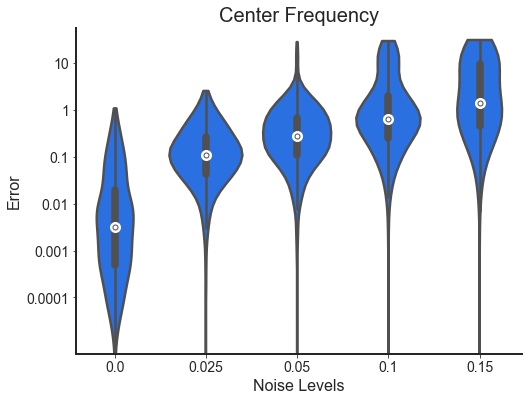

In [27]:
# Plot the error of peak center frequency reconstruction for the low peaks
plot_errors_violin(cf_low_errors, 'Center Frequency', plt_log=PLT_LOG, 
                   ylim=YLIMS_CF, yticks=YTICKS_CF,
                   save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'low_cf_error'))

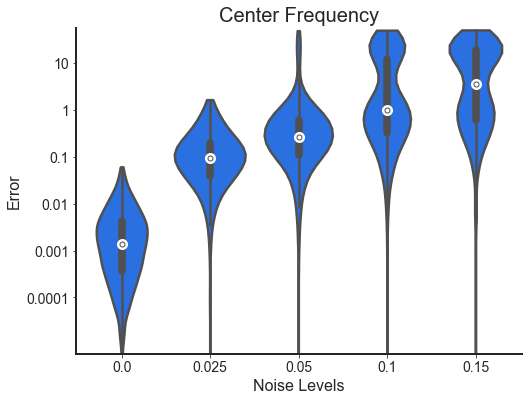

In [28]:
# Plot the error of peak center frequency reconstruction for the high peaks
plot_errors_violin(cf_high_errors, 'Center Frequency', plt_log=PLT_LOG,
                   ylim=YLIMS_CF, yticks=YTICKS_CF,
                   save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'high_cf_error'))

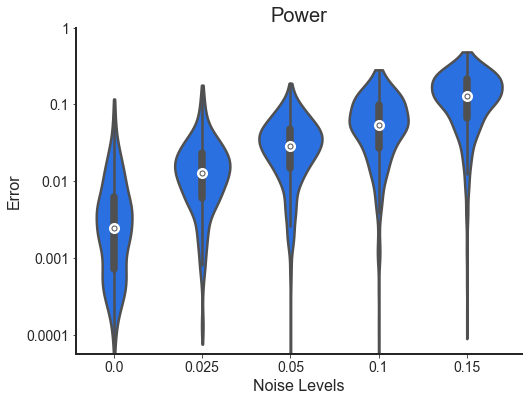

In [29]:
# Plot the error of peak power reconstruction for the low peaks
plot_errors_violin(pw_low_errors, 'Power', plt_log=PLT_LOG,
                   ylim=YLIMS_PW, yticks=YTICKS_PW,
                   save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'low_pw_error'))

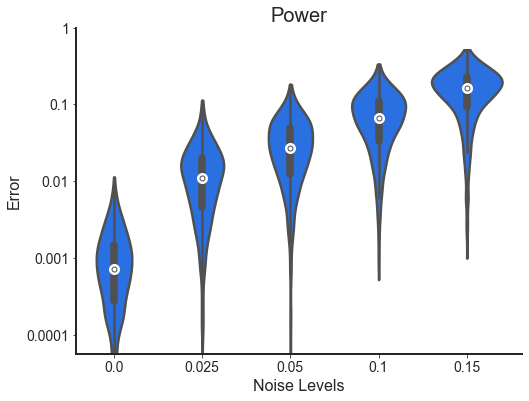

In [30]:
# Plot the error of peak power reconstruction for the low peaks
plot_errors_violin(pw_high_errors, 'Power', plt_log=PLT_LOG,
                   ylim=YLIMS_PW, yticks=YTICKS_PW,
                   save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'high_pw_error'))

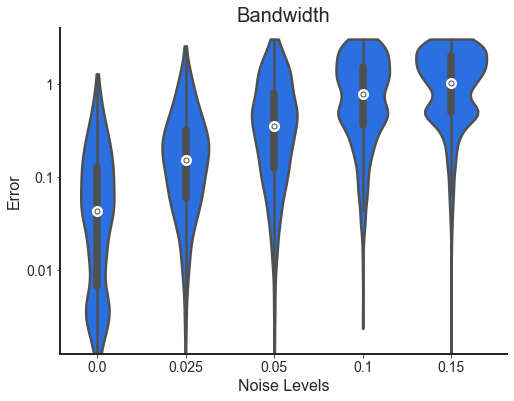

In [31]:
# Plot the error of peak bandwidth reconstruction for the low peaks
plot_errors_violin(bw_low_errors, 'Bandwidth', plt_log=PLT_LOG,
                   ylim=YLIMS_BW, yticks=YTICKS_BW,
                   save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'low_bw_error'))

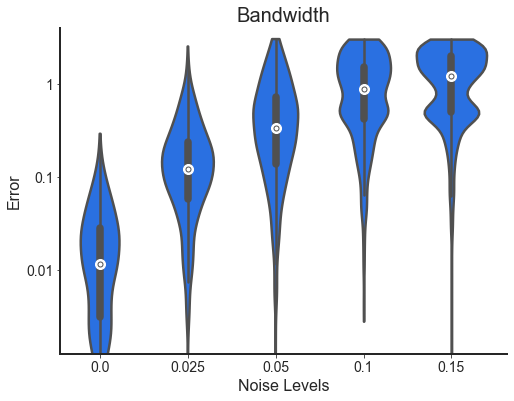

In [32]:
# Plot the error of peak bandwidth reconstruction for the high peaks
plot_errors_violin(bw_high_errors, 'Bandwidth', plt_log=PLT_LOG,
                   ylim=YLIMS_BW, yticks=YTICKS_BW,
                   save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'high_bw_error'))

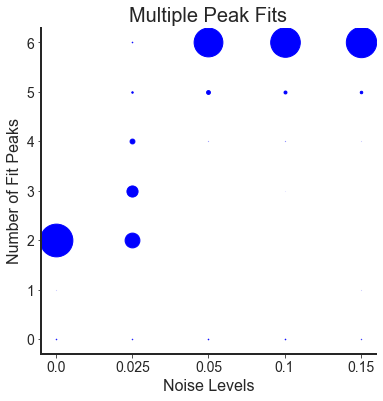

In [33]:
# Plot the number of peak fits per condition, for the low peaks
n_peak_counter_low = count_peak_conditions(n_fit_peaks_low, NLVS)
plot_n_peaks_bubbles(n_peak_counter_low, ms_val=15, x_label='nlvs')

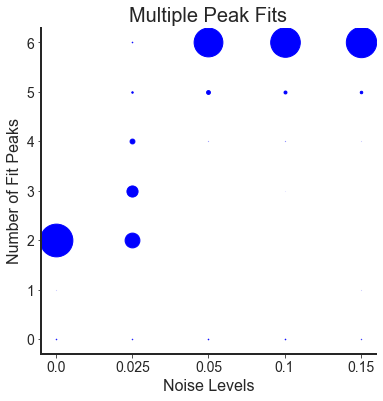

In [34]:
# Plot the number of peak fits per condition, for the high peaks
n_peak_counter_high = count_peak_conditions(n_fit_peaks_high, NLVS)
plot_n_peaks_bubbles(n_peak_counter_high, ms_val=15, x_label='nlvs')

#### Aperiodic Components

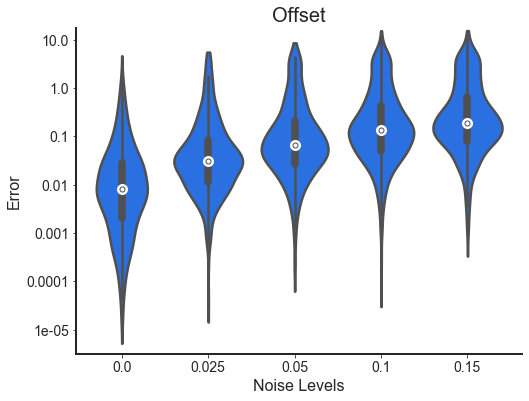

In [35]:
# Plot the error of aperiodic offset reconstruction
plot_errors_violin(off_errors, 'Offset', plt_log=PLT_LOG, ylim=YLIMS_AP2,
                   save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'off_error'))

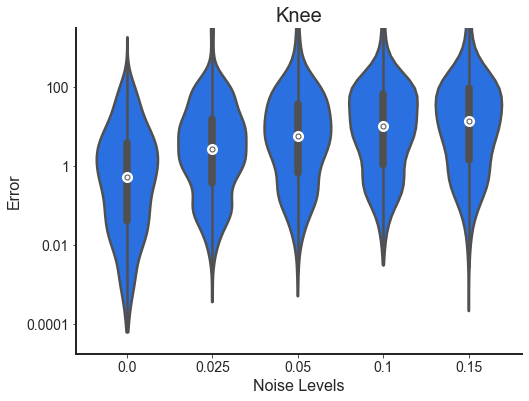

In [36]:
# Plot the error of aperiodic knee reconstruction
plot_errors_violin(kne_errors, 'Knee', plt_log=PLT_LOG, 
                   ylim=YLIMS_KN, yticks=YTICKS_KN,
                   save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'kne_error'))

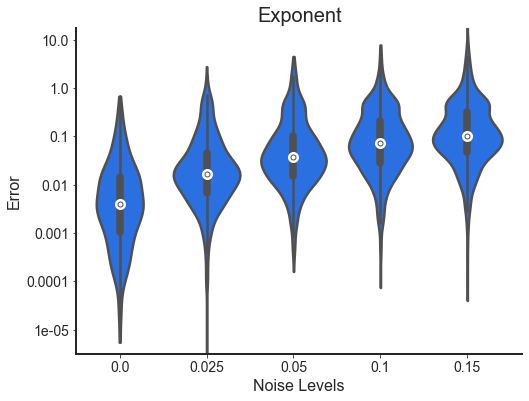

In [37]:
# Plot the error of aperiodic exponent reconstruction
plot_errors_violin(exp_errors, 'Exponent', plt_log=PLT_LOG, ylim=YLIMS_AP2,
                   save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'exp_error'))

#### Goodness of Fit Measures

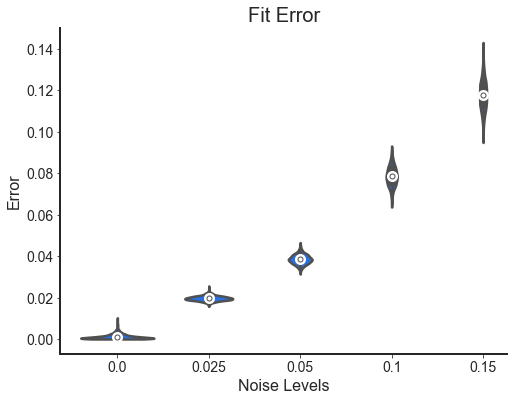

In [38]:
# Plot the amount of error across knee values
plot_errors_violin(err_fits, 'Fit Error', plt_log=False, #x_axis='knees',
                   save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'model_error'))

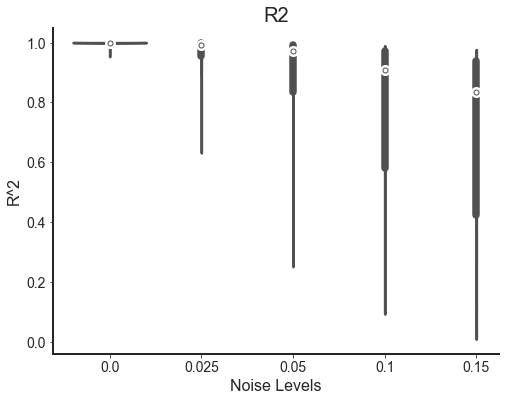

In [39]:
# Plot the goodness-of-fit (R^2) across noise levels
plot_errors_violin(r2_fits, 'R2', y_label='R^2', plt_log=False,
                   save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'model_r_squared'))

### Example FOOOF Fits

SimParams(aperiodic_params=[0, 10, 1.5], periodic_params=[[22, 0.25, 2.0], [80, 0.2, 1.0]], nlv=0.0)
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 1 - 100 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     0.0032, 10.1066, 1.5017                                      
                                                                                                  
        

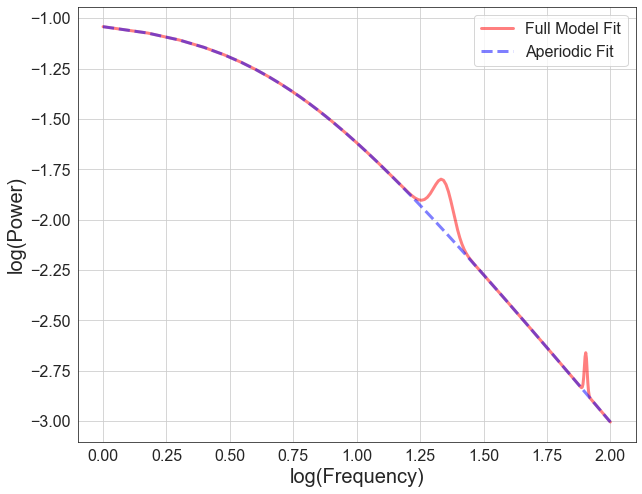

In [40]:
# Grab example cases - low noise
ind = 0
fm1 = fgs[0].get_fooof(ind, True)
print(sim_params[0][ind])
fm1.print_results()
fm1.plot(plt_log=True, save_fig=SAVE_FIG,
         file_path=pjoin(FIGS_PATH, FOLDER), file_name='example_nlv1' + SAVE_EXT)

SimParams(aperiodic_params=[0, 150, 0.5], periodic_params=[[20, 0.25, 1.0], [74, 0.2, 1.0]], nlv=0.15)
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 1 - 100 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     0.1620, 225.6719, 0.8894                                     
                                                                                                  
      

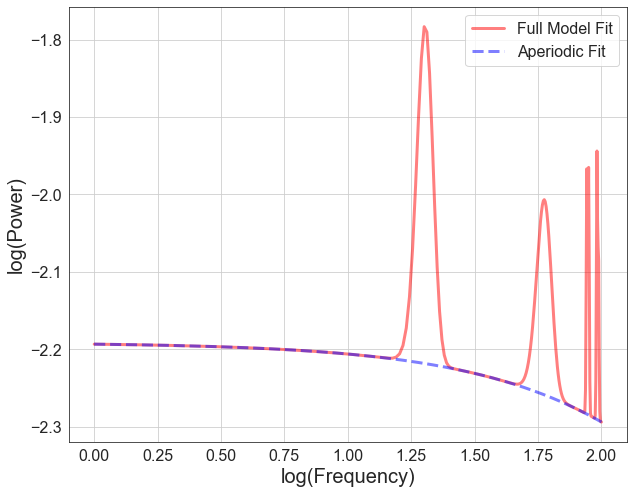

In [42]:
# Grab example cases - high noise
ind = 4
fm5 = fgs[-1].get_fooof(ind, True)
print(sim_params[-1][ind])
fm5.print_results()
fm5.plot(plt_log=True, save_fig=SAVE_FIG, 
         file_path=pjoin(FIGS_PATH, FOLDER), file_name='example_nlv5' + SAVE_EXT)